In [1]:
import yfinance as yf
from ripser import ripser, Rips
import persim 
from persim import plot_diagrams, PersistenceImager
from persim.landscapes import (
    PersLandscapeApprox,
    PersLandscapeExact,
    average_approx, 
    snap_pl, 
    plot_landscape, 
    plot_landscape_simple
)
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from tqdm import tqdm

In [156]:
data = yf.download("^GSPC ^DJI ^IXIC ^RUT", start="1992-01-01", end="2016-12-08", interval = "1d", group_by = "ticker")
data_df = np.log(data.xs("Open", level=1, axis=1).pct_change()+1)
np_data = data_df[1:].to_numpy()
size = 50


[*********************100%***********************]  4 of 4 completed


In [157]:
norm_data = np.zeros(len(np_data)-size)
for i in tqdm(range(len(np_data)-size)):
    arr = np_data[i:i+size]
    dgms = ripser(arr, maxdim=2)['dgms']
    norm_data[i] = PersLandscapeExact(dgms, hom_deg=1).p_norm()

100%|██████████| 6232/6232 [01:38<00:00, 63.13it/s]


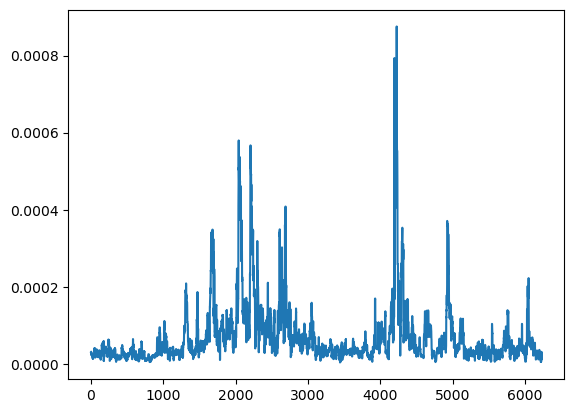

In [158]:
plt.plot(norm_data)

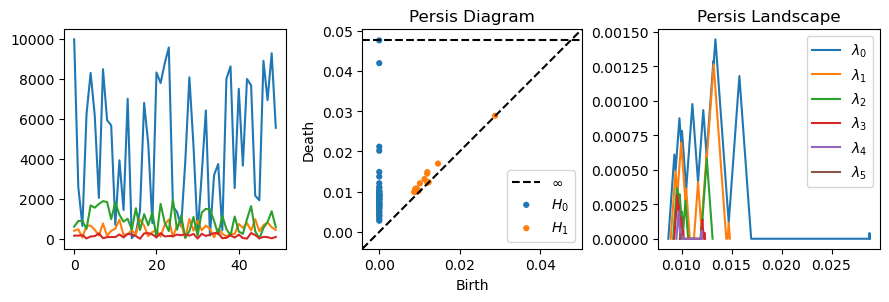

In [150]:
cur = 2027
dgms = ripser(np_data[cur-50:cur], maxdim=1)['dgms']

fig, axs = plt.subplots(1, 3)
fig_size = 3
fig.set_size_inches(fig_size*3, fig_size)

axs[0].plot(np.arange(0, size), arr)

plot_diagrams(dgms, title="Persis Diagram", ax=axs[1])

persim.landscapes.plot_landscape_simple(persim.landscapes.PersLandscapeExact(dgms, hom_deg=1), title="Persis Landscape", ax=axs[2])


fig.tight_layout()

In [151]:
len(data_df[:'2000-02-24'])

2059

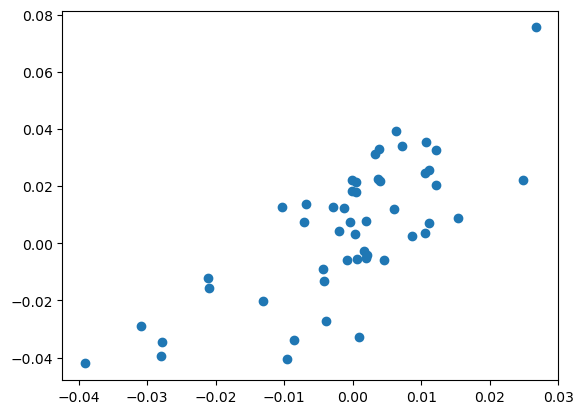

In [153]:
plt.scatter(x = data_df.iloc[2009:2059]["^GSPC"], y =data_df.iloc[2009:2059]["^IXIC"])